In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

(-0.5, 1599.5, 1199.5, -0.5)

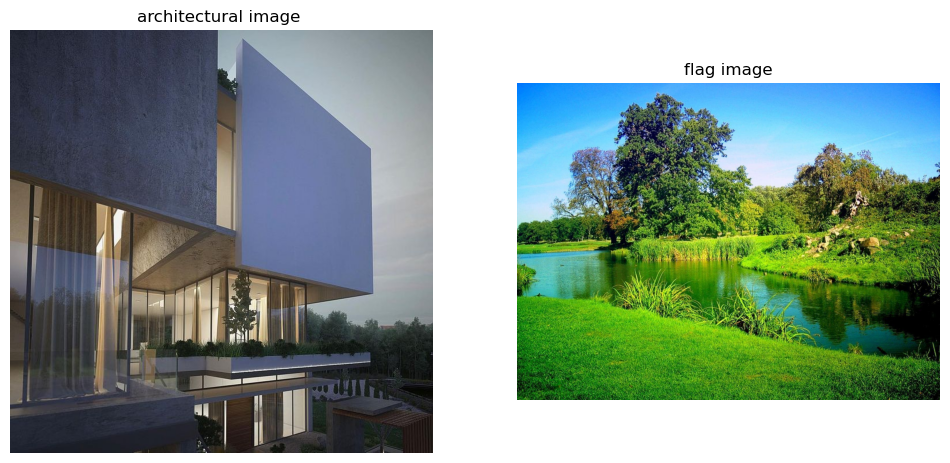

In [5]:
# Load images
architectural_image = cv.imread("../../images/glass.jpg")  
flag_image = cv.imread("../../images/nature.png", cv.IMREAD_UNCHANGED) 
# Create an alpha channel (fully opaque)
alpha_channel = np.ones((flag_image.shape[0], flag_image.shape[1]), dtype=flag_image.dtype) * 255  # Fully opaque

# Combine the RGB channels with the alpha channel
flag_image_with_alpha = cv.merge((flag_image, alpha_channel))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(architectural_image, cv.COLOR_BGR2RGB))
plt.title('architectural image ')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(flag_image_with_alpha, cv.COLOR_BGR2RGB))
plt.title('flag image')
plt.axis('off')

In [6]:
# Function to select points on the image
def select_points(event, x, y, flags, param):
    global points, img_copy
    if event == cv.EVENT_LBUTTONDOWN:
        points.append((x, y))
        cv.circle(img_copy, (x, y), 5, (0, 255, 0), -1)
        cv.imshow("Image", img_copy)


In [7]:
# Prepare variables for point selection
points = []
img_copy = architectural_image.copy()

# Show the architectural image and set up point selection
cv.imshow("Image", img_copy)
cv.setMouseCallback("Image", select_points)
cv.waitKey(0)
cv.destroyAllWindows()

# Ensure we have four points
if len(points) != 4:
    raise ValueError("You must select exactly four points.")

In [8]:
print(points)

[(406, 15), (627, 206), (631, 457), (402, 406)]


In [9]:
flag_image_with_alpha.shape

(1200, 1600, 4)

In [12]:
# Define the corresponding points in the flag image

def blend_image(img1, img2,points):
    flag_height, flag_width = img2.shape[:2]
    flag_corners = np.array([[0, 0], [flag_width, 0], [flag_width, flag_height], [0, flag_height]], dtype="float32")
    points = np.array(points, dtype="float32")
    homography_matrix, _ = cv.findHomography(flag_corners, points)
    warped_img2 = cv.warpPerspective(img2, homography_matrix, (img1.shape[1], img1.shape[0]))
    if warped_img2.shape[2] == 4: 
        flag_mask = (warped_img2[..., 3] > 0).astype(np.uint8)
        warped_img2_rgb = warped_img2[..., :3]
    else:
        flag_mask = np.ones_like(warped_img2[..., 0], dtype=np.uint8) 
        warped_img2_rgb = warped_img2
    transparency_factor = 0.3
    adjusted_flag_mask = flag_mask * transparency_factor  
    adjusted_flag_mask = np.clip(adjusted_flag_mask, 0, 1)

    # Blend the images with the adjusted transparency
    blended_image = img1.copy()
    for c in range(0, 3):
        blended_image[..., c] = (
            blended_image[..., c] * (1 - adjusted_flag_mask) + 
            warped_img2_rgb[..., c] * adjusted_flag_mask
        )
    return blended_image



# Now blended_image contains the architectural image with the flag applied at the specified transparency level


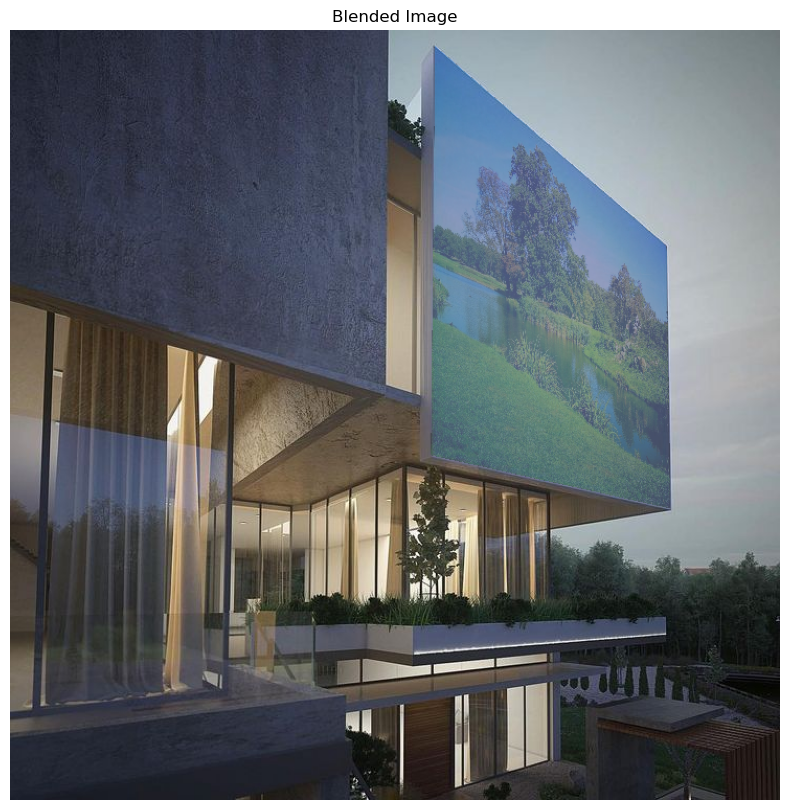

In [13]:
# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(blend_image(architectural_image, flag_image_with_alpha, points), cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Blended Image")
plt.show()